In [1]:
import numpy as np
from pathlib import Path

from discreteMarkovChain import markovChain
import matplotlib.pyplot as plt

# Distributions
from scipy.stats import multivariate_normal
from scipy.stats import beta

# Custom matplotlib stylesheet
stylesheet = (Path.cwd().parent.parent/ 'utilities' / 'metropolis-presentation.mplstyle').as_uri()

# Custom colors
mDarkBrown = '#604C38'
mDarkTeal = '#23373B'
mLightBrown = '#EB811B'
mLightGreen = '#14B03D'

# The Bayesian Paradigm: Priors and Posteriors

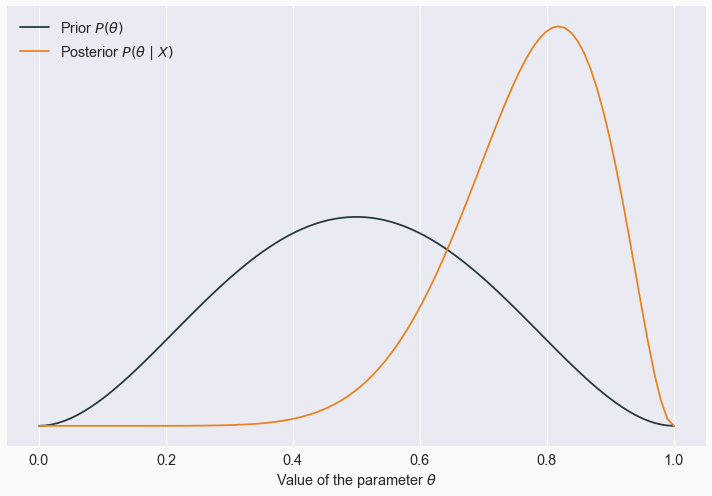

In [2]:
plt.style.use(stylesheet)
fig, ax = plt.subplots()


x = np.linspace(0,1,100)
ax.plot(x, beta.pdf(x, 3, 3), color=mDarkTeal, label=r'Prior $P(\theta)$')
ax.plot(x, beta.pdf(x, 10, 3),color=mLightBrown, label=r'Posterior $P( \theta \mid X )$')


ax.plot()

ax.set_xlabel(r'Value of the parameter $\theta$', fontsize='x-large')
ax.tick_params(axis='x', labelsize='x-large')
ax.get_yaxis().set_visible(False)

ax.legend(fontsize='x-large')

plt.tight_layout()

fig.savefig('../media/prior_and_posterior.png', facecolor=fig.get_facecolor())

# Markov Chain

Here, we implement a simple Markov chain on the with state space $\Theta = \{A, B, C \}$ with transition matrix:

$$ P = \begin{pmatrix}
0.2 & 0.4 & 0.4\\
0.5 & 0.0 & 0.5\\
1.0 & 0.0 & 0.0
\end{pmatrix}.$$

In [3]:
P = np.array([[0.2, 0.4, 0.4],[0.5, 0.0, 0.5],[1.0, 0.0, 0.0]])
mc = markovChain(P)

def transition(theta):
    return int(np.random.choice(3, 1, p=P[theta, :]))

In [4]:
mc.computePi()
print(mc.pi)

[0.5 0.2 0.3]


The invariant distribution of these Markov chain is  $\mu = [ 0.5, 0.2, 0.3 ]$.

In [5]:
mc.computePi()
print(mc.pi)

[0.5 0.2 0.3]


In [6]:
# Here, we simulate the markov chain.
np.random.seed(5)

theta = 0  # Start in state A.
samples = [0]
num_samples = 500  # Stop the Markov chain after 500 steps.

visits = {
    0 : 1,
    1 : 0,
    2 : 0
}

prop_time = {
    0 : [1],
    1 : [0],
    2 : [0]
}

for i in range(2, num_samples + 1):
    
    theta = transition(theta)
    
    visits[theta] += 1
    samples.append(theta)
    for s in range(3):
        prop_time[s].append(visits[s]/i)

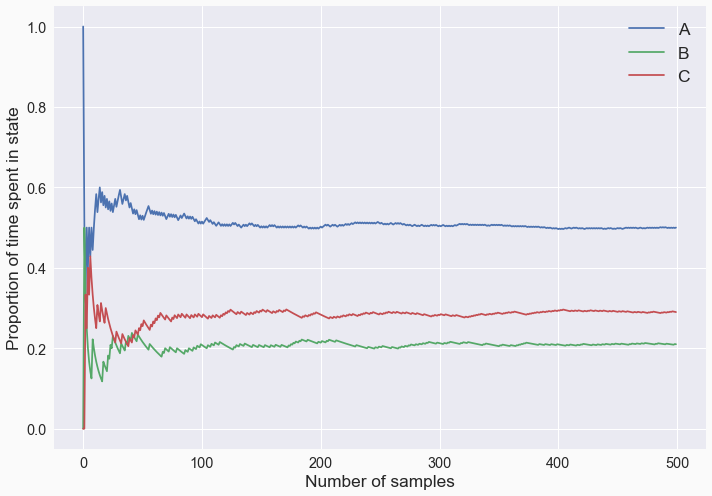

In [7]:
# Plot the proportion of time spent in each state, as a function of the number of samples.

plt.style.use(stylesheet)
fig, ax = plt.subplots()

line_A, = ax.plot(prop_time[0], label='A')
line_B, = ax.plot(prop_time[1], label='B')
line_C, = ax.plot(prop_time[2], label='C')

ax.set_xlabel('Number of samples')
ax.set_ylabel('Proportion of time spent in state')

ax.legend(handles=[line_A, line_B, line_C])

plt.tight_layout()

fig.savefig('../media/markov_chain_simulation', facecolor=fig.get_facecolor())


We see empirically that the proportion of time spent in state $i$ is $\sim \mu(i)$, where $\mu$ is the invariant distribution computed at the start of the section.

This behaviour is formally explained by the Ergodic Theorem for Markov Chains (for instance, see [these notes](http://www.statslab.cam.ac.uk/~rrw1/markov/M.pdf)).

# The Metropolis Algorithm

In this section, we implement the Metropolis algorithm in the case of two-dimensional distribution.

In [8]:
def metropolis_2d(f, num_samples, x_start, std_dev):
    
    samples = []
    x_current = x_start
    num_accepted = 0
    for i in range(num_samples):
        
        # Generate a proposal.
        x_proposal = np.random.multivariate_normal(x_current, cov=std_dev**2 * np.eye(2))
        
        #Compute the acceptance probability.
        p_accept = min(1, f(x_proposal)/f(x_current))
        
        # "Flip a coin": with probability p_accept, we accept the proposal.
        if np.random.binomial(1, p_accept):
            x_current = x_proposal
            num_accepted += 1
                
        samples.append(x_current)
    
    acc_rate = num_accepted/num_samples
    
    return samples, acc_rate

In [9]:
def visaulise_chain(samples, acc_rate, std_dev, output_file):
    
    x_samples, y_samples = zip(*samples)
    
    fig, ax = plt.subplots(figsize=(9,9))
    
    ax.set_xlim(-10,10)
    ax.set_ylim(-10,10)
    
    ax.plot(x_samples, y_samples, color=mDarkTeal, linewidth='0.2', markersize=5, marker='.')
    ax.plot(x_samples[1], y_samples[1], color='red', markersize=5, marker='o')  # the starting point
    
    ax.set_title(f'Proposal Standard Deviation = {std_dev} \nAcceptance Rate = {acc_rate} ')
    plt.tight_layout()
    
    fig.savefig(output_file, facecolor=fig.get_facecolor())

Next, we visualise the chains produced by the Metropolis algorithm for a standard 2D normal distirbution, for various values of the standard deviation for the proposal distribution.

Note how the acceptance rate depends on the value of the standard deviation.

In [10]:
f = multivariate_normal(mean=[0,0], cov=np.identity(2)).pdf
num_samples=1000
x_start=(7,7)

###### std_dev = 5

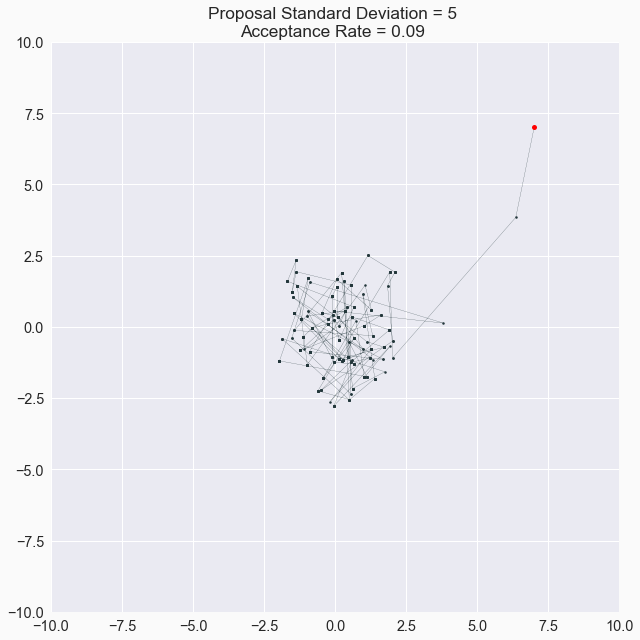

In [11]:
np.random.seed(29)
std_dev = 5
output_file = '../media/metropolis_large_std_dev.png'

samples, acc_rate = metropolis_2d(f, num_samples=num_samples, x_start=x_start, std_dev=std_dev)
visaulise_chain(samples=samples, acc_rate=acc_rate, std_dev=std_dev, output_file=output_file)

###### std_dev = 1

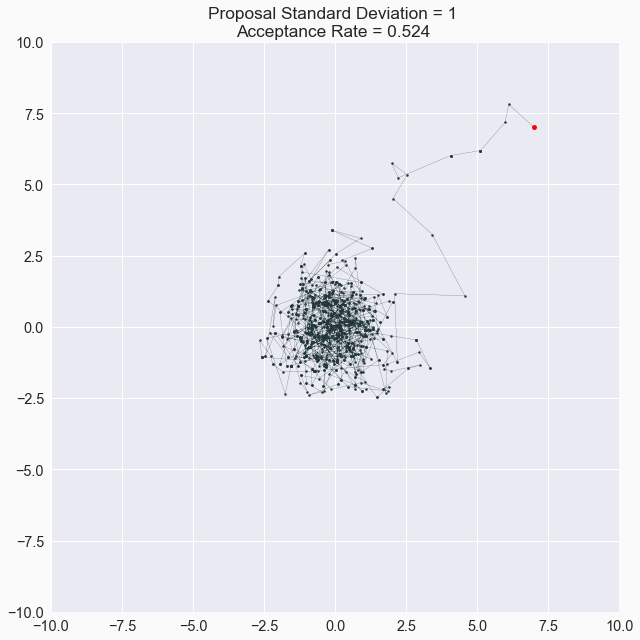

In [12]:
np.random.seed(29)
std_dev = 1
output_file = '../media/metropolis_medium_std_dev.png'

samples, acc_rate = metropolis_2d(f, num_samples=num_samples, x_start=x_start, std_dev=std_dev)
visaulise_chain(samples=samples, acc_rate=acc_rate, std_dev=std_dev, output_file=output_file)

###### std_dev = 0.1

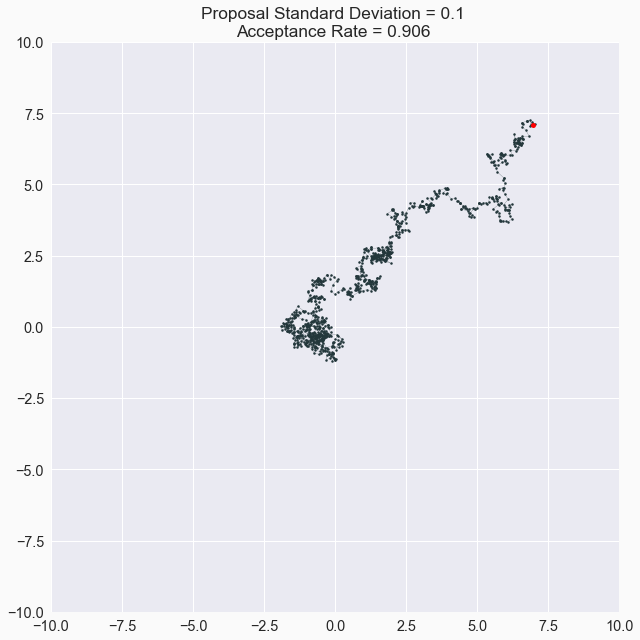

In [13]:
np.random.seed(29)
std_dev = 0.1
output_file = '../media/metropolis_small_std_dev.png'

samples, acc_rate = metropolis_2d(f, num_samples=num_samples, x_start=x_start, std_dev=std_dev)
visaulise_chain(samples=samples, acc_rate=acc_rate, std_dev=std_dev, output_file=output_file)